In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle
%cd '/content/kaggle'

In [23]:
!echo '{"username":"USERNAME","key":"KEY"}' > /root/.kaggle/kaggle.json

In [24]:
!kaggle datasets download -d cashutosh/gender-classification-dataset

 96% 258M/269M [00:04<00:00, 43.0MB/s]
100% 269M/269M [00:04<00:00, 66.9MB/s]


In [25]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Validation/male/067031.jpg.jpg  
  inflating: Validation/male/067038.jpg.jpg  
  inflating: Validation/male/067040.jpg.jpg  
  inflating: Validation/male/067046.jpg.jpg  
  inflating: Validation/male/067048.jpg.jpg  
  inflating: Validation/male/067054.jpg.jpg  
  inflating: Validation/male/067064.jpg.jpg  
  inflating: Validation/male/067068.jpg.jpg  
  inflating: Validation/male/067069.jpg.jpg  
  inflating: Validation/male/067086.jpg.jpg  
  inflating: Validation/male/067091.jpg.jpg  
  inflating: Validation/male/067099.jpg.jpg  
  inflating: Validation/male/067101.jpg.jpg  
  inflating: Validation/male/067102.jpg.jpg  
  inflating: Validation/male/067112.jpg.jpg  
  inflating: Validation/male/067117.jpg.jpg  
  inflating: Validation/male/067119.jpg.jpg  
  inflating: Validation/male/067133.jpg.jpg  
  inflating: Validation/male/067143.jpg.jpg  
  inflating: Validation/male/067152.jpg.jpg  
  inflating: Validation/male/

In [26]:
train_dir = './Training'
val_dir = './Validation'

In [27]:
train_dir_male = train_dir + '/male'
train_dir_female = train_dir + '/female'

val_dir_male  = val_dir + '/male'
val_dir_female  = val_dir + '/female'

print('number of male training images - ',len(os.listdir(train_dir_male)))
print('number of female training images - ',len(os.listdir(train_dir_female)))
print('----------------------------------------------------------------------')
print('number of male validation  images - ',len(os.listdir(val_dir_male)))
print('number of female validation  images - ',len(os.listdir(val_dir_female)))

number of male training images -  23766
number of female training images -  23243
----------------------------------------------------------------------
number of male validation  images -  5808
number of female validation  images -  5841


In [28]:
classes = os.listdir(train_dir)
print(classes)

['male', 'female']


In [29]:
train_datagen = ImageDataGenerator( # Data Augumentation for test data
rescale=1./255,
rotation_range=30,
shear_range=0.3,
zoom_range=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [30]:
train_gen=train_datagen.flow_from_directory(train_dir,
                                            target_size=(250,250),
                                            batch_size=48,
                                            class_mode='binary')

Found 47009 images belonging to 2 classes.


In [31]:
valid_gen=test_datagen.flow_from_directory(val_dir,
                                           target_size=(250,250),
                                           batch_size=48,
                                           class_mode='binary')

Found 11649 images belonging to 2 classes.


In [32]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([64,64]),
        #transforms.RandomCrop(64, padding=50, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
])

valid_tfms = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor(), transforms.Normalize(*stats)])
train_ds = ImageFolder(train_dir, transform=train_tfms)
val_ds = ImageFolder(val_dir, transform=valid_tfms)

In [34]:
batch_size = 256

In [35]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [36]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

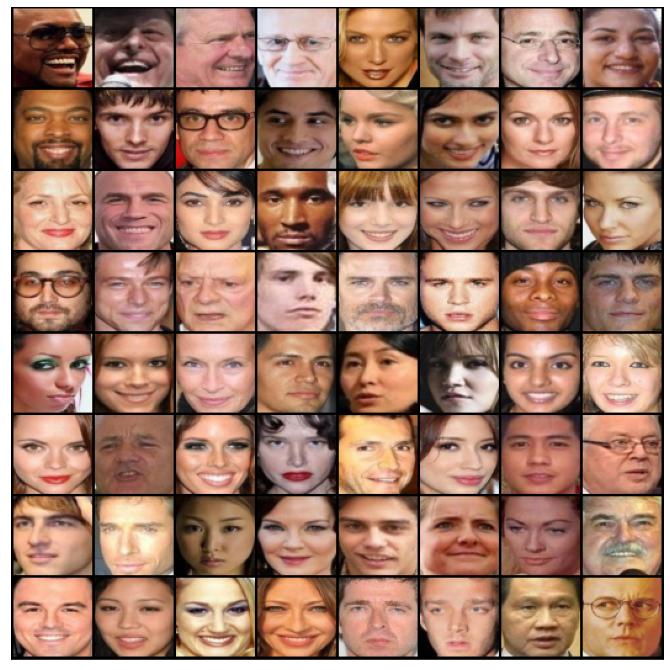

In [37]:
show_batch(train_dl)

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [42]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64, pool=True)    # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 X 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [43]:
model = to_device(Resnet9(3, 2), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [44]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [45]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.5039911866188049, 'val_loss': 0.6997110247612}]

In [46]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [47]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00394, train_loss: 0.2548, val_loss: 0.1342, val_acc: 0.9495
Epoch [1], last_lr: 0.00935, train_loss: 0.1760, val_loss: 0.1180, val_acc: 0.9578
Epoch [2], last_lr: 0.00972, train_loss: 0.1444, val_loss: 0.1178, val_acc: 0.9610
Epoch [3], last_lr: 0.00812, train_loss: 0.1132, val_loss: 0.0926, val_acc: 0.9669
Epoch [4], last_lr: 0.00556, train_loss: 0.0998, val_loss: 0.1508, val_acc: 0.9444
Epoch [5], last_lr: 0.00283, train_loss: 0.0866, val_loss: 0.0769, val_acc: 0.9728
Epoch [6], last_lr: 0.00077, train_loss: 0.0695, val_loss: 0.0676, val_acc: 0.9764
Epoch [7], last_lr: 0.00000, train_loss: 0.0507, val_loss: 0.0671, val_acc: 0.9764
CPU times: user 51.1 s, sys: 23.4 s, total: 1min 14s
Wall time: 5min 11s


In [48]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

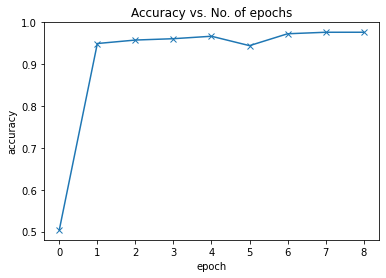

In [49]:
plot_accuracies(history)

In [50]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

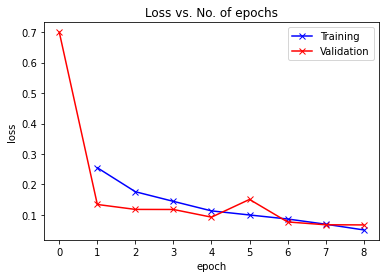

In [52]:
plot_losses(history)

In [53]:
test_dataset = ImageFolder(val_dir, transform=valid_tfms)

In [54]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: female , Predicted: female


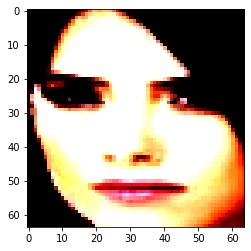

In [55]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: male , Predicted: male


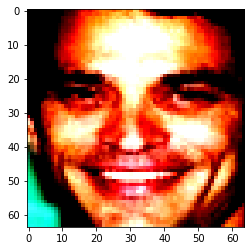

In [56]:
img, label = test_dataset[10000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: male , Predicted: female


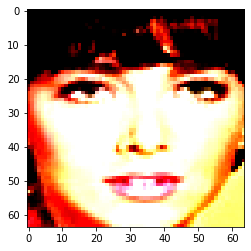

In [57]:
img, label = test_dataset[10876]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: female , Predicted: female


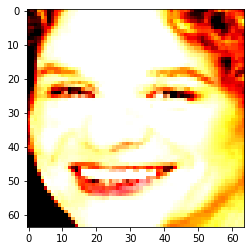

In [58]:
img, label = test_dataset[2096]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: female , Predicted: female


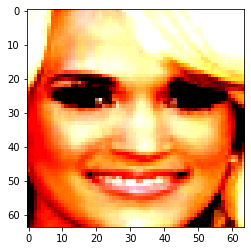

In [59]:
img, label = test_dataset[5420]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: female , Predicted: female


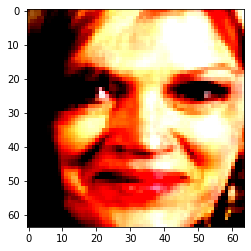

In [60]:
img, label = test_dataset[43]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: female , Predicted: female


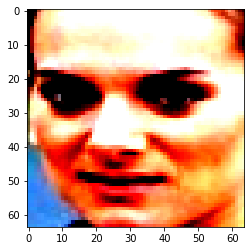

In [62]:
img, label = test_dataset[31]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))